Sample Features (log + standardized):
 [[7.59458686 1.9481811 ]
 [5.11641298 0.23245282]
 [4.99079577 2.01357909]
 [4.46213172 1.02254122]
 [4.26845855 0.9505546 ]]
Sample Target (numeric after LabelEncoder):
 [1 1 1 1 1]

LinearRegression
------------------------------
Mean Squared Error: 0.3754
Top 5 Candidates (indices by predicted talent): [ 633  183 2314 2193  431]

PolynomialRegression
------------------------------
Mean Squared Error: 0.3260
Top 5 Candidates (indices by predicted talent): [2314  431 1441 1394 1878]

Ridge
------------------------------
Mean Squared Error: 0.3754
Top 5 Candidates (indices by predicted talent): [ 633  183 2314 2193  431]

Lasso
------------------------------
Mean Squared Error: 0.3987
Top 5 Candidates (indices by predicted talent): [ 633  183 2314 2193  431]

ElasticNet
------------------------------
Mean Squared Error: 0.3862
Top 5 Candidates (indices by predicted talent): [ 633  183 2314 2193  431]

DecisionTree
------------------------------
Me

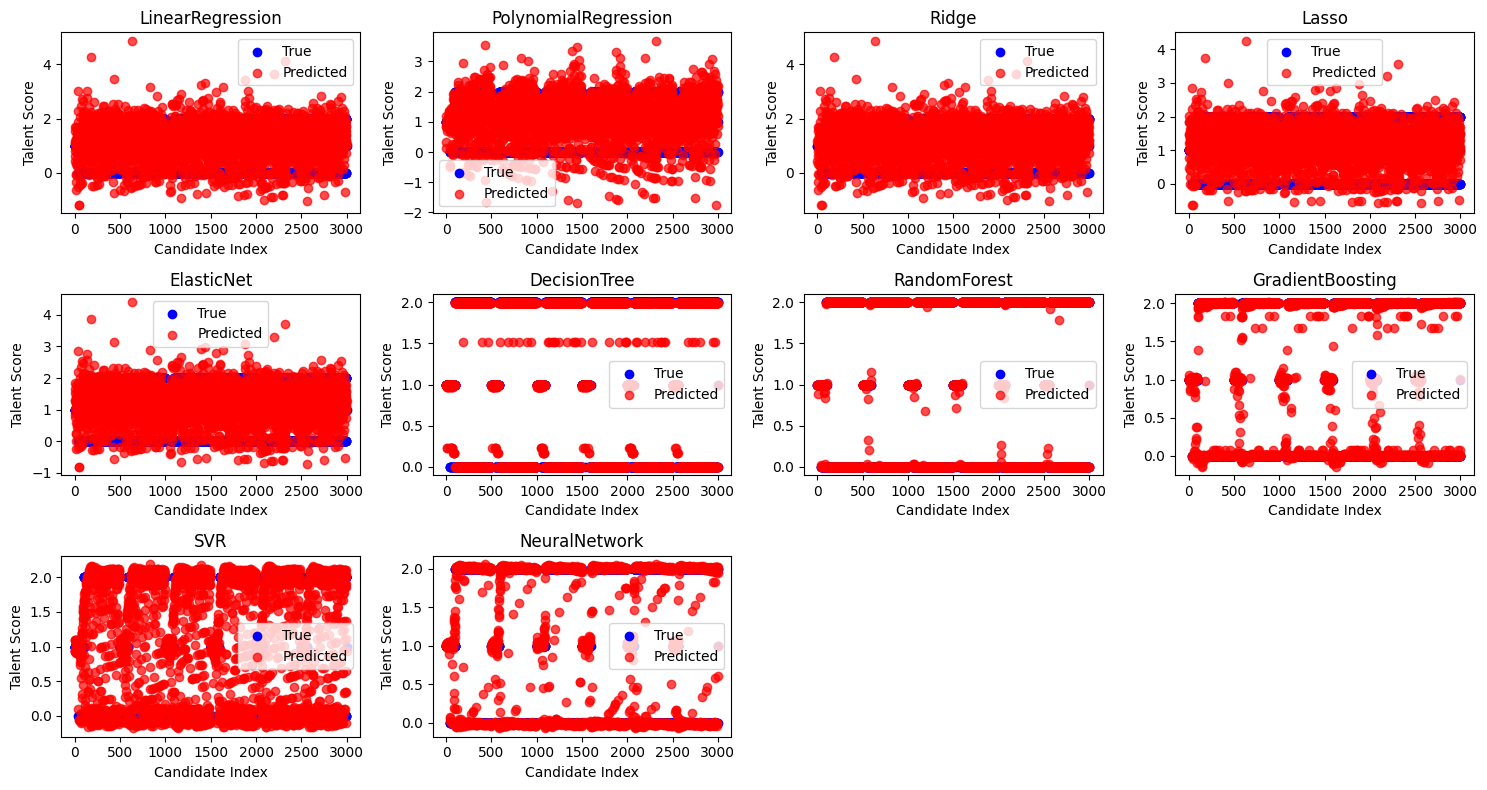

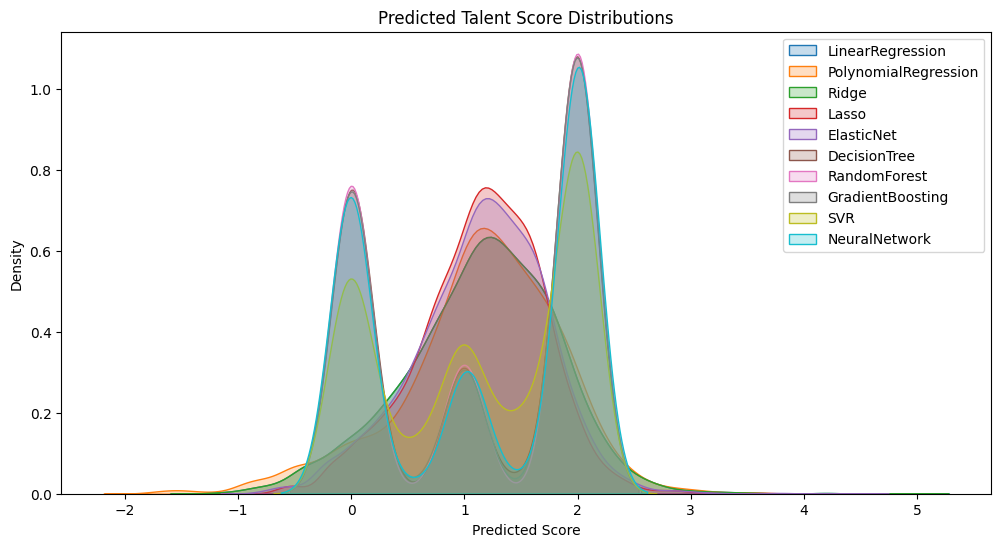


Ranking Comparison (Top 10 candidate indices):
   LinearRegression  PolynomialRegression  Ridge  Lasso  ElasticNet  \
0               633                  2314    633    633         633   
1               183                   431    183    183         183   
2              2314                  1441   2314   2314        2314   
3              2193                  1394   2193   2193        2193   
4               431                  1878    431    431         431   
5              1878                  2193   1878   1878        1878   
6              1441                  1915   1441   1441        1441   
7              1394                   825   1394     32        1394   
8               825                  2934    825   1632        1632   
9              1632                  1472   1632   1394         825   

   DecisionTree  RandomForest  GradientBoosting   SVR  NeuralNetwork  
0           802           808              2951   825           2314  
1          2121          212

In [6]:
# github_regression_analysis_labelencoded.py
# Regression analysis using preprocessed GitHub features with label-encoded talent_level

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# ---------------------------
# 1. Load and Preprocess Data
# ---------------------------
df = pd.read_csv('github_global_talent.csv')
df['followers'] = df['followers'].fillna(0)
df['public_repos'] = df['public_repos'].fillna(0)

# Log transform features to handle extreme outliers
df['log_followers'] = np.log1p(df['followers'])
df['log_repos'] = np.log1p(df['public_repos'])

# Standardize features
scaler = StandardScaler()
X_talent = scaler.fit_transform(df[['log_followers', 'log_repos']])

# Load target and label-encode
df_target = pd.read_csv('github_talent_analysis_results.csv')
le = LabelEncoder()
y_talent = le.fit_transform(df_target['talent_level'])

print("Sample Features (log + standardized):\n", X_talent[:5])
print("Sample Target (numeric after LabelEncoder):\n", y_talent[:5])

# ---------------------------
# 2. Polynomial Features for Non-linear Models
# ---------------------------
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_talent)

# ---------------------------
# 3. Define Regression Models
# ---------------------------
models = {
    "LinearRegression": LinearRegression(),
    "PolynomialRegression": LinearRegression(),  # will use X_poly
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "DecisionTree": DecisionTreeRegressor(max_depth=3),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf', C=100, epsilon=0.1),
    "NeuralNetwork": MLPRegressor(hidden_layer_sizes=(50,50), max_iter=2000, random_state=42)
}

# ---------------------------
# 4. Fit Models, Predict, Evaluate
# ---------------------------
results = {}
for name, model in models.items():
    if name == "PolynomialRegression":
        model.fit(X_poly, y_talent)
        y_pred = model.predict(X_poly)
    else:
        model.fit(X_talent, y_talent)
        y_pred = model.predict(X_talent)
    
    mse = mean_squared_error(y_talent, y_pred)
    ranking = np.argsort(-y_pred)  # descending ranking (higher = better candidate)
    
    results[name] = {
        "predictions": y_pred,
        "MSE": mse,
        "ranking": ranking
    }
    
    print(f"\n{name}")
    print("-"*30)
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Top 5 Candidates (indices by predicted talent): {ranking[:5]}")

# ---------------------------
# 5. Visualizations
# ---------------------------
output_dir = "github_talent_analysis_results"
os.makedirs(output_dir, exist_ok=True)

# True vs Predicted
plt.figure(figsize=(15,8))
for i, (name, res) in enumerate(results.items()):
    plt.subplot(3,4,i+1)
    plt.scatter(range(len(y_talent)), y_talent, label="True", color='blue')
    plt.scatter(range(len(y_talent)), res['predictions'], label="Predicted", color='red', alpha=0.7)
    plt.title(name)
    plt.xlabel("Candidate Index")
    plt.ylabel("Talent Score")
    plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "true_vs_predicted.png"))
plt.show()

# Predicted Score Distributions
plt.figure(figsize=(12,6))
for name, res in results.items():
    sns.kdeplot(res['predictions'], label=name, fill=True)
plt.title("Predicted Talent Score Distributions")
plt.xlabel("Predicted Score")
plt.ylabel("Density")
plt.legend()
plt.savefig(os.path.join(output_dir, "score_distributions.png"))
plt.show()

# ---------------------------
# 6. Ranking Comparison
# ---------------------------
ranking_df = pd.DataFrame({name: res['ranking'] for name, res in results.items()})
print("\nRanking Comparison (Top 10 candidate indices):")
print(ranking_df.head(10))

# Save predictions and rankings
df_results = df.copy()
df_results['talent_level'] = y_talent
for name, res in results.items():
    df_results[f"{name}_pred"] = res['predictions']

df_results.to_csv(os.path.join(output_dir, "regression_predictions_and_rankings.csv"), index=False)
print(f"\nAll predictions, rankings, and plots saved in folder: {output_dir}")
